###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Computation of Sensitivity Kernels by 2D acoustic FD modelling

Beside the modelling of seismic surveys, our 2D acoustic FD code can be used as the core of a seismic full waveform inversion (FWI) approach. A very efficient implementation is possible in the frequency domain.

The aim of acoustic frequency domain FWI is to minimize the data residuals $\mathbf{\delta \tilde{P} = \tilde{P}^{mod} - \tilde{P}^{obs}}$ between the modelled frequency domain data $\mathbf{\tilde{P}^{mod}}$ and field data $\mathbf{\tilde{P}^{obs}}$ to deduce high resolution models of the P-wave velocity distribution in the subsurface. To solve this non-linear inversion problem, an objective function E, as a measure of the data misfit, has to be defined. The classical choice is the L2-norm of the data residuals

\begin{equation} 
E  = ||\mathbf{\delta \tilde{P}}||_2 = \frac{1}{2}\mathbf{\delta \tilde{P}}^\dagger \mathbf{\delta \tilde{P}} = \frac{1}{2} \sum_{k=1}^{n_\omega} \sum_{i=1}^{ns} \sum_{j=1}^{nr} \delta \tilde{P}^*(\mathbf{x_s}_i, \mathbf{x_r}_j, \omega_k) \delta \tilde{P}(\mathbf{x_s}_i, \mathbf{x_r}_j, \omega_k) \notag
\end{equation}  

where ns and nr are the number of shots and receivers, $n_\omega$ the number of discrete frequencies, $\dagger$ the complex transpose, $*$ the complex conjugate, $\mathbf{x_s},\; \mathbf{x_r}$  the source and receiver positions, respectively. The objective function can be minimized by iteratively updating the P-wave velocity $\mathbf{Vp}$ at iteration step n, starting with an initial background model $\mathbf{Vp_0}$, along a search direction using the **Newton** method:

\begin{equation} 
\mathbf{Vp}_{n+1} = \mathbf{Vp}_{n} - \mu_n \mathbf{H}_n^{-1} \left(\mathbf{\frac{\partial E}{\partial Vp}}\right)_n, \notag
\end{equation}  

where $\mu$ denotes the step length, $\mathbf{\frac{\partial E}{\partial Vp}}$ the gradient and ${\mathbf H}$ the second derivative (Hessian) of the objective function with respect to $\mathbf{Vp}$. The step length $\mu_{n}$ can be estimated by an inexact parabolic line search.

The gradient $\mathbf{\frac{\partial E}{\partial Vp}}$ can be calculated by

\begin{equation} 
\mathbf{\frac{\partial E}{\partial Vp}} = - \mathbf{K}^\dagger \delta P, \notag
\end{equation}  

where $\mathbf{K}$ denotes the **Sensitivity Kernel**:

\begin{equation} 
K(x,z,\omega) = {\cal{Re}}\biggl\{\frac{2 \omega^2}{Vp^3} \frac{\tilde{P}(x,z,\omega,\mathbf{x_{s}}) \tilde{G}(x,z,\omega,\mathbf{x_{r}})}{max(\tilde{P}(x,z,\omega,\mathbf{x_{s}}))}\biggr\}
\end{equation} 

with the monochromatic forward wavefield $\tilde{P}(x,z,\omega,\mathbf{x_s})$ excitated at the source position $\mathbf{x_s}$ and the Green's function $\tilde{G}(x,z,\omega,\mathbf{x_r})$ excitated at the receiver postion $\mathbf{x_r}$, $\cal{Re}$ denotes the real part.

## Computation of monochromatic frequency domain wavefields from time-domain wavefields by Discrete Fourier Transform (DFT)

To compute the sensitivity kernel eq. (1), we first need to estimate monochromatic frequency domain wavefields from the time domain wavefields. This can be easily implemented in our 2D acoustic FD code by the **Discrete Fourier Transform (DFT)** within the time-loop of the FD code. We approximate the continous Fourier transform 

\begin{equation}
\tilde{f}(\omega) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} f(t) exp(-i \omega t) dt \notag
\end{equation}

by

\begin{equation}
\tilde{f_i}(\omega) \approx \frac{1}{2 \pi} \sum_{n=0}^{nt} f_n(t_n) \biggl(cos(\omega t_n)-i\; sin(\omega t_n)\biggr) dt \notag
\end{equation}

with $nt$ the number of time steps in the FD code, $\omega = 2 \pi f$ the circular frequency based on the frequency $f$, $i^2 = -1$. The wavefield can be further decomposed into the real 

\begin{equation}
Re\{\tilde{f_i}(\omega)\} \approx \frac{1}{2 \pi} \sum_{n=0}^{nt} f_n(t_n) \biggl(cos(2 \pi f t_n)\biggr) dt \notag
\end{equation}

and imaginary part

\begin{equation}
Im\{\tilde{f_i}(\omega)\} \approx -\frac{1}{2 \pi} \sum_{n=0}^{nt} f_n(t_n) \biggl(sin(2 \pi f t_n)\biggr) dt \notag
\end{equation}

The implementation into the FD code is quite straightforward. During the time-stepping we have to multiply the time-domain pressure wavefield by a geometrical factor and add the contributions. Let's implement it into our 2D acoustic FD code and try to compute the frequency domain wavefields for a homogeneous background model and a first arrival traveltime tomography result of the Marmousi-2 model ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

As always, we start with the definition of the basic modelling parameters ...

In [3]:
# Definition of modelling parameters
# ----------------------------------

# Define model discretization
nx = 500    # number of grid points in x-direction
nz = 174    # number of grid points in z-direction
dx = 20.0   # spatial grid point distance in x-direction (m)
dz = dx     # spatial grid point distance in z-direction (m)

# Define xmax, zmax
xmax = nx * dx
zmax = nz * dz

# Define maximum recording time
tmax =  6.0 # maximum wave propagation time (s)

# Define source and receiver position
xsrc =  2000.0 # x-source position (m)
zsrc =  40.0   # z-source position (m)

xrec =  8000.0 # x-receiver position (m)
zrec =  40.0   # z-source position (m)

f0   = 10 # dominant frequency of the source (Hz)
print("f0 = ", f0, " Hz")
t0   = 4.0/f0   # source time shift (s)

isnap = 2  # snapshot interval (timesteps)

# Calculate monochromatic wavefields for discrete frequency freq
freq = 5.0 # discrete frequency (Hz)

f0 =  10  Hz


... define a JIT-ed function for the spatial FD approximation ...

In [4]:
@jit(nopython=True) # use JIT for C-performance
def update_d2px_d2pz_3pt(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
                
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz 

... initialize the absorbing boundary frame ...

In [5]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

In the 2D FD acoustic modelling code, we implement the DFT of the time-domain wavefields, by initializing the real and imaginary parts of the pressure wavefields, calculate the trigonometric factors for the DFT within the time-loop, apply the DFT to the pressure wavefield `p` for the discrete frequency `freq` and finally return the real and imaginary parts of the frequency domain wavefields ...

In [6]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT(vp,dt,dx,dz,f0,xsrc,zsrc,op,freq):        
    
    # calculate number of time steps nt 
    # ---------------------------------
    nt = (int)(tmax/dt)
    
    # locate source on Cartesian FD grid
    # ----------------------------------
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction    
    
    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2)) 
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.1 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Define squared vp-model
    # -----------------------        
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p 
    
    # INITIALIZE ARRAYS FOR REAL AND IMAGINARY PARTS OF MONOCHROMATIC WAVEFIELDS HERE! 
    # --------------------------------------------------------------------------------
    p_real = np.zeros((nx,nz)) # real part of the monochromatic wavefield 
    p_imag = np.zeros((nx,nz)) # imaginary part of the monochromatic wavefield 
        
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(7,3))  # define figure size
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot Vp-model
    image = plt.imshow((vp.T)/1000, cmap=plt.cm.gray, interpolation='nearest', 
                        extent=extent)    
    
    # Plot pressure wavefield movie
    image1 = plt.imshow(p.T, animated=True, cmap="RdBu", alpha=.75, extent=extent, 
                          interpolation='nearest', vmin=-clip, vmax=clip)    
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
           
    plt.ion()    
    plt.show(block=False)
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        if(op==3):
            d2px, d2pz = update_d2px_d2pz_3pt(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
        
        # Apply absorbing boundary frame
        # ------------------------------
        p *= absorb_coeff
        pnew *= absorb_coeff
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
        
        # Calculate frequency domain wavefield at discrete frequency freq by DFT
        # ----------------------------------------------------------------------
        time = it * dt  # time
        trig1 = np.cos(2.0 * time * freq * np.pi) * dt # real part
        trig2 = np.sin(2.0 * time * freq * np.pi) * dt # imaginary part
        
        # Estimate real and imaginary part of pressur wavefield p by DFT
        # --------------------------------------------------------------
        p_real += p * trig1
        p_imag += p * trig2
    
        # display pressure snapshots 
        if (it % isnap) == 0:            
            image1.set_data(p.T)
            fig.canvas.draw()
    
    # Finalize computation of DFT
    p_real =   p_real / (2.0 * np.pi)
    p_imag = - p_imag / (2.0 * np.pi)
    
    # Return real and imaginary parts of the monochromatic wavefield
    return p_real, p_imag

## Modelling monochromatic frequency domain wavefields for a homogeneous acoustic medium

Now, everything is assembled to compute frequency domain wavefields. We only have to define the discrete frequency `freq` for which the monochromatic wavefields should be calculated. Let's start with a homogeneous model:

<IPython.core.display.Javascript object>


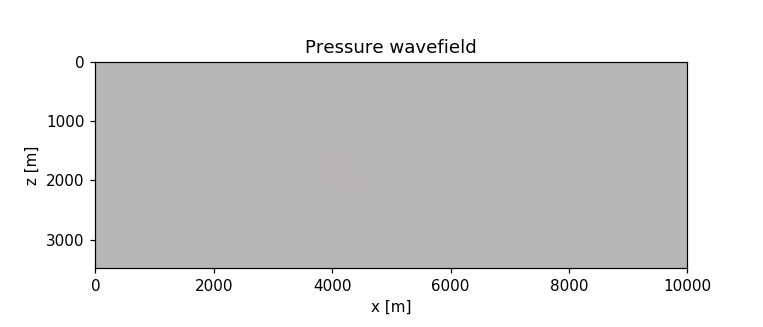

In [7]:
# Run 2D acoustic FD modelling with 3-point spatial operater
# ----------------------------------------------------------
%matplotlib notebook
op = 3  # define spatial FD operator (3-point) 

# define homogeneous model with vp = 2500 m/s
vp_hom = 2500.0 * np.ones((nx,nz))

# Define time step
dt =  dx / (np.sqrt(2) * np.max(vp_hom))# time step (s)

p_hom_re, p_hom_im = FD_2D_acoustic_JIT(vp_hom,dt,dx,dz,f0,xsrc,zsrc,op,freq)

The time domain wavefields seem to be correct. Let's take a look at the frequency domain wavefield:

<IPython.core.display.Javascript object>


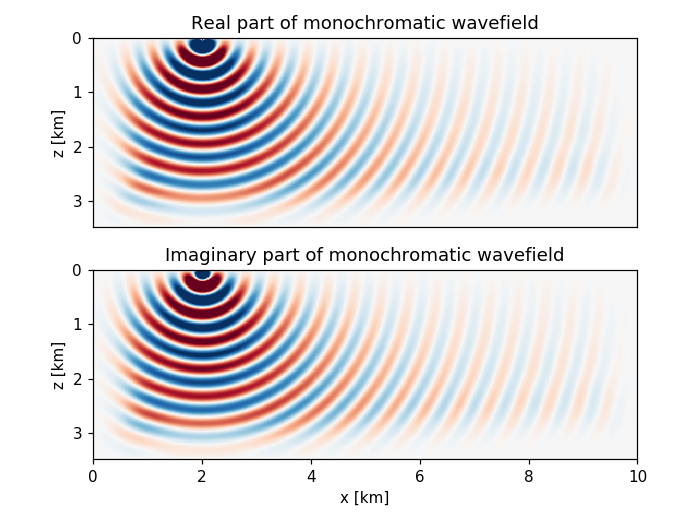

In [8]:
%matplotlib notebook
# Plot real and imaginary parts of monochromatic wavefields
clip_seis = 5e-10
extent_seis = [0.0,xmax/1000,zmax/1000,0.0]

ax = plt.subplot(211)
plt.imshow(p_hom_re.T, cmap=plt.cm.RdBu, aspect=1, vmin=-clip_seis, 
                   vmax=clip_seis, extent=extent_seis)

plt.title('Real part of monochromatic wavefield')
#plt.xlabel('x [km]')
ax.set_xticks([]) 
plt.ylabel('z [km]')


plt.subplot(212)
plt.imshow(p_hom_im.T, cmap=plt.cm.RdBu, aspect=1, vmin=-clip_seis, 
                   vmax=clip_seis, extent=extent_seis)
plt.title('Imaginary part of monochromatic wavefield')
plt.xlabel('x [km]')
plt.ylabel('z [km]')
plt.tight_layout()
plt.show()

## Modelling monochromatic frequency domain wavefields for the Marmousi-2 FATT model

In the next step, we calculate monochromatic wavefields for the first arrival traveltime tomography (FATT) result of the Marmousi-2 model, which could be an initial model for a subsequent FWI. First, we import the FATT model to Python:

In [9]:
# Import FATT result for Marmousi-2 Vp model
# ------------------------------------------

# Define model filename
name_vp = "marmousi-2/marmousi_II_fatt.vp"

# Open file and write binary data to vp
f = open(name_vp)
data_type = np.dtype ('float32').newbyteorder ('<')
vp_fatt = np.fromfile (f, dtype=data_type)

# Reshape (1 x nx*nz) vector to (nx x nz) matrix 
vp_fatt = vp_fatt.reshape(nx,nz)

<IPython.core.display.Javascript object>


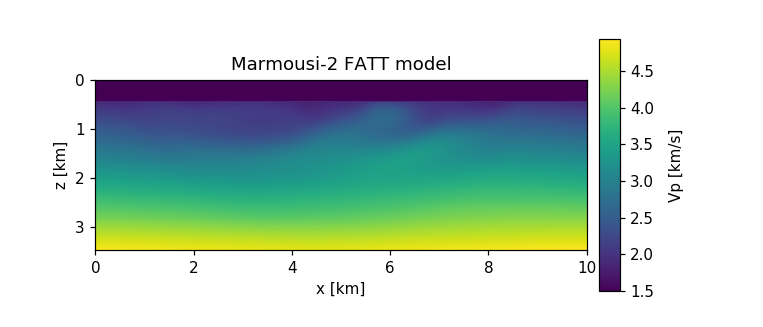

In [10]:
# Plot Marmousi-2 vp-model
# ------------------------
%matplotlib notebook
extent = [0, xmax/1000, zmax/1000, 0]
fig = plt.figure(figsize=(7,3))  # define figure size
image = plt.imshow((vp_fatt.T)/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                   extent=extent)


cbar = plt.colorbar(aspect=12, pad=0.02)
cbar.set_label('Vp [km/s]', labelpad=10)
plt.title('Marmousi-2 FATT model')
plt.xlabel('x [km]')
plt.ylabel('z [km]')
plt.show()

... and run the time-domain modelling code:

<IPython.core.display.Javascript object>


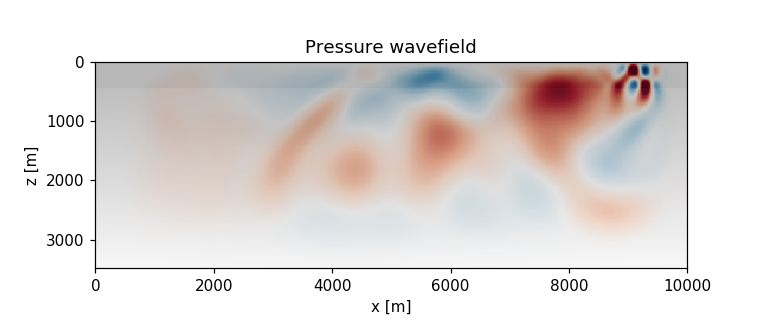

In [11]:
# Run 2D acoustic FD modelling with 3-point spatial operater
# ----------------------------------------------------------
%matplotlib notebook
op = 3  # define spatial FD operator (3-point) 

# Define time step by CFL criterion
dt =  dx / (np.sqrt(2) * np.max(vp_fatt))# time step (s)

p_fatt_re, p_fatt_im = FD_2D_acoustic_JIT(vp_fatt,dt,dx,dz,f0,xsrc,zsrc,op,freq)

<IPython.core.display.Javascript object>


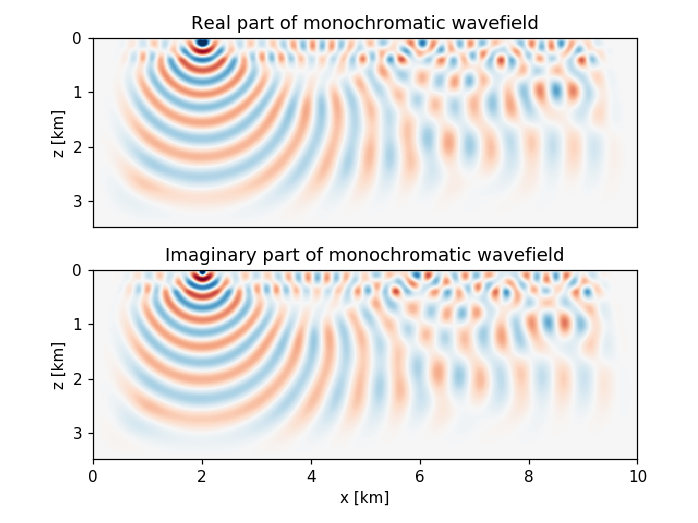

In [12]:
%matplotlib notebook
# Plot real and imaginary parts of monochromatic wavefields
clip_seis = 5e-9
extent_seis = [0.0,xmax/1000,zmax/1000,0.0]

ax = plt.subplot(211)
plt.imshow(p_fatt_re.T, cmap=plt.cm.RdBu, aspect=1, vmin=-clip_seis, 
                   vmax=clip_seis, extent=extent_seis)

plt.title('Real part of monochromatic wavefield')
#plt.xlabel('x [km]')
ax.set_xticks([]) 
plt.ylabel('z [km]')


plt.subplot(212)
plt.imshow(p_fatt_im.T, cmap=plt.cm.RdBu, aspect=1, vmin=-clip_seis, 
                   vmax=clip_seis, extent=extent_seis)
plt.title('Imaginary part of monochromatic wavefield')
plt.xlabel('x [km]')
plt.ylabel('z [km]')
plt.tight_layout()
plt.show()

## Sensitivity Kernels

The monochromatic frequency domain wavefields are the key to calculate sensitivty kernels, which will be computed in the next exercise ...

##### Exercise

Compute 5 Hz frequency domain sensitivity kernels 

\begin{equation} 
K(x,z,\omega) = {\cal{Re}}\biggl\{\frac{2 \omega^2}{Vp^3} \frac{\tilde{P}(x,z,\omega,\mathbf{x_{s}}) \tilde{G}(x,z,\omega,\mathbf{x_{r}})}{max(\tilde{P}(x,z,\omega,\mathbf{x_{s}}))}\biggr\} \notag
\end{equation}

for the homogenous and FATT Marmousi-2 model. 

- The frequency domain forward wavefields $\tilde{P}(x,z,\omega,\mathbf{x_{s}})$ for a source at $x_{s} = 2000.0\; m$ and  $z_{s} = 40.0\; m$ where already computated in the previous sections of the notebook (`p_hom_re`, `p_hom_im`,`p_fatt_re`, `p_fatt_im`). You only have to compute the receiver Green's functions $\tilde{G}(x,z,\omega,\mathbf{x_{r}})$ by placing a source at the receiver position $x_{r} = 8000.0\; m$ and  $z_{r} = 40.0\; m$
- Compute the sensitivity kernels $K(x,z,\omega)$. Hint: In Python complex numbers are defined as `real_part + 1j*imag_part`. This can also be applied to `NumPy` arrays.
- Plot, describe and interpret the sensitivity kernels for the homogeneous and Marmousi-2 FATT model. Where would you expect model updates in a subsequent FWI? 

In [ ]:
# COMPUTE RECEIVER GREEN'S FUNCTION FOR HOMOGENEOUS MODEL HERE!
# -------------------------------------------------------------
%matplotlib notebook
op = 3  # define spatial FD operator (3-point) 

# Define time step
dt =  dx / (np.sqrt(2) * np.max(vp_hom))# time step (s)

g_hom_re, g_hom_im = FD_2D_acoustic_JIT(vp_hom,dt,dx,dz,f0,xsrc,zsrc,op,freq)

In [ ]:
%matplotlib notebook

# COMPUTE SENSITVITY KERNEL FOR HOMOGENEOUS MODEL HERE!

clip = 4e-18
extent = [0.0,xmax/1000,zmax/1000,0.0] # define model extension

fig = plt.figure(figsize=(7,3))  # define figure size

# Plot Vp-model
image = plt.imshow((vp_hom.T)/1000, cmap=plt.cm.gray, interpolation='nearest', 
                    extent=extent)    

# Plot Sensitivity Kernel
image1 = plt.imshow(K_hom.T, cmap="RdBu", alpha=.75, extent=extent, 
                      interpolation='nearest', vmin=-clip, vmax=clip)    
plt.title('Sensitivity Kernel (homogeneous model)')
plt.xlabel('x [km]')
plt.ylabel('z [km]')

plt.show()

In [ ]:
# COMPUTE RECEIVER GREEN'S FUNCTION FOR MARMOUSI-2 FATT MODEL HERE!
# -----------------------------------------------------------------
%matplotlib notebook
op = 3  # define spatial FD operator (3-point) 

# Define time step
dt =  dx / (np.sqrt(2) * np.max(vp_fatt))# time step (s)

g_fatt_re, g_fatt_im = FD_2D_acoustic_JIT(vp_fatt,dt,dx,dz,f0,xsrc,zsrc,op,freq)

In [ ]:
%matplotlib notebook

# COMPUTE SENSITVITY KERNEL FOR Marmousi-2 FATT MODEL HERE!

clip = 8e-17
extent = [0.0,xmax/1000,zmax/1000,0.0] # define model extension

fig = plt.figure(figsize=(7,3))  # define figure size

# Plot Vp-model
image = plt.imshow((vp_fatt.T)/1000, cmap=plt.cm.gray, interpolation='nearest', 
                    extent=extent)    

# Plot Sensitivity Kernel
image1 = plt.imshow(K_hom.T, cmap="RdBu", alpha=.5, extent=extent, 
                      interpolation='nearest', vmin=-clip, vmax=clip)    
plt.title('Sensitivity Kernel (Marmousi-2 FATT model)')
plt.xlabel('x [km]')
plt.ylabel('z [km]')

plt.show()

## What we learned:

- How to compute monochromatic frequency domain wavefields from time-domain wavefields by discrete Fourier transform (DFT)
- Computation of sensitivity kernels